<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/LASSO_AQshort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting AQ-Short and its subfactors**


# Get code from Github
This notebook is largely the same as RPS_AQ28corr.py    if you want to run it from command line locally.

In [9]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("AIiRPS") is None:
  !git clone https://github.com/AraiKensuke/AIiRPS.git

sys.path.insert(1, "/content/AIiRPS")


# Pick a target (soc_skils, imag, rout, switch, fact_pat, AQ28scrs), and run cross-validated LASSO repeat 100 times, and look at r^2.

Functions that attempt to do somethings about outliers.

In [47]:
import numpy as _N
import matplotlib.pyplot as _plt
import scipy.stats as _ss
from sklearn import linear_model
import sklearn.linear_model as _skl
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import LassoCV


def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm

lm = depickle("/content/AIiRPS/predictAQ28dat/AQ28_vs_RPS.dmp")

AQ28scores = ["AQ28scrs", "soc_skils", "imag", "rout", "switch", "fact_pat"]
AQ28scores_ab = ["AQ28", "SS", "IM", "RT", "SW", "FP"]

outcomes = ["netwins",
            "win_aft_win", "tie_aft_win", "los_aft_win",            
            "win_aft_tie", "tie_aft_tie", "los_aft_tie",
            "win_aft_los", "tie_aft_los", "los_aft_los",
            "u_or_d_tie", "u_or_d_res", "stay_tie", "stay_res"]
outcome_ab = ["NW",
              "WW", "TW", "LW",
              "WT", "TT", "LT",
              "WL", "TL", "LL",
              "T", "W"]  #  0.5 3.5 6.5 9.5


rule_change_features = ["pfrm_change36", "pfrm_change69", "pfrm_change912", "moresim"]

features = ["entropyT2", "entropyW2", "entropyL2", "entropyU", "entropyS", "entropyD",
            "isis_corr", "isis_lv", "entropyL", "entropyT", "entropyW"]
#            "pfrm_change36", "pfrm_change69", "pfrm_change912"]

for feat in features:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : feat})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : feat})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : feat})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : feat})
for outc in outcomes:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : outc})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : outc})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : outc})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : outc})
for scrs in AQ28scores:
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : scrs})
for rcf in rule_change_features:
    #exec("%(f)s = lm[\"AQ28_%(f)s\"][:, 1]" % {"f" : rcf})
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : rcf})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : rcf})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : rcf})
#Xs_train = Xs_train / _N.std(Xs_train, axis=0)

####################  USE ALL DATA
filtdat = _N.arange(AQ28scrs.shape[0])
####################  OUR DATA HAS 1 very strong outlier - 1 person with 
####################  AQ-28 score of 30 or so.  Next closest person has 
####################  score of 42 (or so).  
####################  using these 
filtdat = _N.where((AQ28scrs > 35) & (rout > 4))[0]
for scrs in AQ28scores:
    exec("%(f)s = lm[\"%(f)s\"]" % {"f" : scrs})
    exec("%(f)s = %(f)s / _N.std(%(f)s)" % {"f" : scrs})
    exec("%(f)s = %(f)s - _N.mean(%(f)s)" % {"f" : scrs})
print("Using %(fd)d of %(all)d participants" % {"fd" : len(filtdat), "all" : AQ28scrs.shape[0]})
all_features = features + outcomes + rule_change_features
#X            = _N.empty((AQ28scrs.shape[0], len(all_features)))
X            = _N.empty((len(filtdat), len(all_features)))
iaf = -1
for af in all_features:
    iaf += 1
    exec("feat = %s" % af)
    X[:, iaf] = feat[filtdat]

scrs = _N.empty(100)
for i in range(100):
    y    = fact_pat[filtdat]
    nrep = 1
    rkf = RepeatedKFold(n_splits=4, n_repeats=nrep)#, random_state=0)
    reg = LassoCV(cv=rkf, max_iter=3000).fit(X, y)
    scrs[i] = reg.score(X, y)


Using 164 of 166 participants


([], <a list of 0 Text major ticklabel objects>)

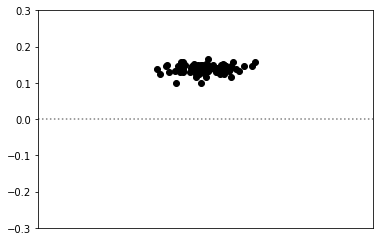

In [45]:
_plt.scatter(_N.random.randn(100)*0.05, scrs, color="black")
_plt.xlim(-0.4, 0.4)
_plt.ylim(-0.3, 0.3)
_plt.axhline(y=0, ls=":", color="grey")
_plt.xticks([])


In [46]:
_N.mean(scrs)


0.13851817219602

In [39]:
len(ths)

164

In [40]:
AQ28scrs.shape[0]

166